# Variational Autoencoder

Example is from the [Keras blog](https://blog.keras.io/building-autoencoders-in-keras.html). According to the writer it's the simplest possible autoencoder.

In [36]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size

x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

print(x_train.shape)
print(x_test.shape)

intermediate_dim = 500
batch_size = 128
# You would assume that 10 latent dimensions would be best for the MNIST dataset...
latent_dim = 2
epochs = 50
input_shape = (original_dim, )

(60000, 784)
(10000, 784)


In [27]:
# Build encoder

# The input is mapped to a hidden layer "h" with dimension "intermediate_dim" and then mapped immediately to 
# a latent layer with Gaussians (mean and log sigma variables). All subsequent layers are fully connected.
inputs = Input(input_shape)
h = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim)(h)
z_log_variance = Dense(latent_dim)(h)

Given mean, $\mu$, and (log) sigma, $\log \sigma$, sample from a Normal distribution: $z \sim N(\mu, \sigma^2)$.

Here Lambda is actually a layer. It accepts a vector with means and sigmas and returns a vector with samples

Rather than directly sampling from $N(\mu,\sigma^2)$ we sample from $\epsilon \sim N(0,1)$ and calculate $z = \mu + \sigma \odot \epsilon$. Note that this function expects $\log \sigma$, not $\log \sigma^2$. The above representation is a product-wise multiplication by $\sigma$, but represents $N(\mu,\sigma^2)$.

In [28]:
from keras.layers import Lambda
from keras import backend as K

def sampling(args):
    z_mean, z_log_variance = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    # It stated z_mean + K.exp(z_log_sigma) * epsilon in original code, but actually log variance was used
    # in Kullback-Leibler divergence. Hence I changed z_log_sigma -> z_log_variance and divide here by 2 in the
    # exponent, corresponds to sqrt(z_variance).
    return z_mean + K.exp(z_log_variance / 2) * epsilon

z = Lambda(sampling)([z_mean, z_log_variance])

In [29]:
# instantiate encoder, from inputs to latent space
encoder = Model(inputs, [z_mean, z_log_variance, z])

In [30]:
# Build decoder model
# The latent Gaussian variables are mapped to again a layer with dimension "intermediate_dim", finally the 
# reconstruction is formed by mapping to original dimension.
# If properly trained, x_decoded_mean should be the same as x.
decoder_input = Input(shape=(latent_dim,))
decoder_h = Dense(intermediate_dim, activation='relu')(decoder_input)
decoder_output = Dense(original_dim, activation='sigmoid')(decoder_h)
#x_decoded_mean = decoder_mean(h1)

# Instantiate decoder
decoder = Model(decoder_input, decoder_output)

In [31]:
# end-to-end autoencoder
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs)

The loss for the Variational Autoencoder is:
* a "binary cross-entropy" loss between x and x' (the reconstructed x_decoded_mean)
* a Kullback-Leibler divergence with the latent layer

The Kullback-Leibler divergence between two multivariate normal distributions:

$$D_{KL}(N_0,N_1) = 1/2 \left( \mathrm{tr }(\Sigma_1^{-1}\Sigma_0) + (\mu_1 - \mu_0)^T\Sigma_1^{-1} (\mu_1 - \mu_0) -k + \log \frac{\det \Sigma_1}{ \det \Sigma_0} \right)$$

Here $\Sigma_0$ and $\Sigma_1$ are covariance matrices. 

In our case we compare a diagonal multivariate normal (one $\sigma$ scalar per variable) with a unit normal distribution. The trace of a matrix is just the sum over the diagonal. The determinant of a diagonal matrix is the product over the diagonal. The unit normal distribution: $\Sigma_1 = I$, $\mu_1=0$ (vector notation omitted).

$$D_{KL}(N_0,N_1) = 1/2 \left( \sum_k ( \Sigma_0 ) + (-\mu_0)^T (-\mu_0) -k - \log  \prod_k (\Sigma_0) \right)$$

And:

$$D_{KL}(N_0,N_1) = 1/2 \left( \sum_k ( \Sigma_0 ) + \sum_k (\mu_i^2) + \sum_k ( -1 ) - \sum_k \log \Sigma_0 \right)$$

Which leads to:

$$D_{KL}(N_0,N_1) = -1/2 \sum_{i=1}^k 1 + \log(\sigma_i^2) - \mu_i^2 - \sigma_i^2$$

Here $N_0 = N(\mu_1,\ldots,\mu_k;\sigma_1,\ldots,\sigma_k)$ and $N_1 = N(0,I)$. We use the standard deviation $\sigma_i$ here rather than the (co)variance $\Sigma$.

Note, it seems that z_log_sigma here actually represents $\log \sigma^2$. Is this correct?

Rather than K.sum() for the KL divergence K_mean() is used. The entire loss is scaled with the original dimension. It would also have been an option to multiply the xend_loss with original_dim and then return the sum.

In [32]:
from keras import objectives
from keras.losses import mse, binary_crossentropy

def vae_loss(x, x_reconstruction):
    xent_loss = binary_crossentropy(x, x_reconstruction) * original_dim
    # if we set kl_loss to 0 we get low values pretty immediate...
    # in 1 epoch, loss: 0.1557 - val_loss: 0.1401
    # in 50 epochs, loss: 0.0785 - val_loss: 0.0791 
    kl_loss = - 0.5 * K.sum(1 + z_log_variance - K.square(z_mean) - K.exp(z_log_variance), axis=-1)
    return K.mean(xent_loss + kl_loss)

vae.compile(optimizer='adam', loss=vae_loss)
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 784)               0         
_________________________________________________________________
model_6 (Model)              [(None, 2), (None, 2), (N 394504    
_________________________________________________________________
model_7 (Model)              (None, 784)               394284    
Total params: 788,788
Trainable params: 788,788
Non-trainable params: 0
_________________________________________________________________


In [37]:
steps_per_epoch=None
vae.fit(x_train, x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))
vae.save_weights('vae_mlp_mnist.h5')

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 13s 220us/step - loss: 159.2221 - val_loss: 159.0399
Epoch 2/50
60000/60000 [==============================] - 13s 219us/step - loss: 157.8996 - val_loss: 157.8228
Epoch 3/50
60000/60000 [==============================] - 14s 228us/step - loss: 156.7433 - val_loss: 157.0596
Epoch 4/50
60000/60000 [==============================] - 13s 219us/step - loss: 155.8518 - val_loss: 156.1105
Epoch 5/50
60000/60000 [==============================] - 13s 218us/step - loss: 155.0062 - val_loss: 155.4488
Epoch 6/50
60000/60000 [==============================] - 13s 219us/step - loss: 154.3491 - val_loss: 155.1011
Epoch 7/50
60000/60000 [==============================] - 13s 217us/step - loss: 153.6979 - val_loss: 154.3355
Epoch 8/50
60000/60000 [==============================] - 13s 220us/step - loss: 153.1956 - val_loss: 154.0257
Epoch 9/50
60000/60000 [==============================] - 13s 

In [39]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs, _, _, = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

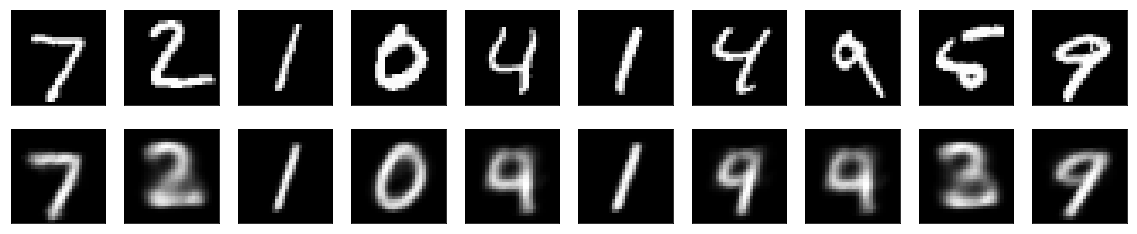

In [40]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [86]:
x_test_encoded, _, _ = encoder.predict(x_test, batch_size=batch_size)

with plt.style.context(['default','ggplot','seaborn-pastel'], after_reset=True):
    plt.figure(figsize=(6, 6))
    plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test/10, cmap='Blues')
    plt.colorbar()
    plt.show()

ModuleNotFoundError: No module named 'matplotlib.pyplot.seaborn'; 'matplotlib.pyplot' is not a package